### Imports

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings(action="ignore")

### Connect to drive and load data

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_path = "drive/MyDrive/data_ids_challenge"

df_data = pd.read_csv(f"{dir_path}/ML-EdgeIIoT-dataset-processed.csv", index_col=0)
df_label = pd.read_csv(f"{dir_path}/ML-EdgeIIoT-dataset-labels.csv", index_col=0)

## Split the data to train and test

In [4]:
for col in ['Attack_type']:
    df_label[col], _ = pd.factorize(df_label[col])

In [5]:
from sklearn.model_selection import train_test_split

#### Binary classification

Note that the train test split is splitting the data and saves the same balance between the data labeled 1 and the data labeled 0 in the train and test batches

In [6]:
X_train_full_b, X_test_b, y_train_full_b, y_test_b = train_test_split(df_data, df_label['Attack_label'], random_state=42)
X_train_b, X_valid_b, y_train_b, y_valid_b = train_test_split(X_train_full_b, y_train_full_b, random_state=42)

#### Multiclass classification

In [7]:
X_train_full_m, X_test_m, y_train_full_m, y_test_m = train_test_split(df_data, df_label['Attack_type'], random_state=42)
X_train_m, X_valid_m, y_train_m, y_valid_m = train_test_split(X_train_full_m, y_train_full_m, random_state=42)

## Random forest

#### Binary classification

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [9]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, oob_score=True)
rnd_clf.fit(X_train_full_b, y_train_full_b)

y_pred_rf = rnd_clf.predict(X_test_b)

In [10]:
from joblib import dump
dump(rnd_clf, 'rf_model.joblib')

['rf_model.joblib']

#### Evaluation
Accuracy - How many classification were right (can be missleading when the classes are not balanced as it is now)

Precision - The proportion of TP among postive predictions

Recall - The proportion of TP among all the actual positive values (helps understand if your model is missing something)

F1-Score - The harmonic mean of Recall and Precision which gives us a balanced view of both

ROC - Helps us visualize the tradeoff between FPR and TPR (the perfect ROC value is 1)

In [13]:
print(accuracy_score(y_test_b, y_pred_rf))

0.9730291508238277


This is a very good success rate (even though making a complete guess on the output label brings you to 0.8447148288973384% accuracy (because the label data is unbalanced))

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [17]:
precision = precision_score(y_test_b, y_pred_rf)
recall = recall_score(y_test_b, y_pred_rf)
f1 = f1_score(y_test_b, y_pred_rf)

# Use predict_proba for ROC curve
if hasattr(rnd_clf, "predict_proba"):
  y_proba = rnd_clf.predict_proba(X_test_b)[:, 1]
  auc = roc_auc_score(y_test_b, y_proba)
else:
  auc = None

In [18]:
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")
print(f"auc: {auc}")

precision: 0.968986825230267
recall: 1.0
f1: 0.9842491710090006
auc: 0.99661105216702


#### Plot ROC curve

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_b, y_pred_rf)

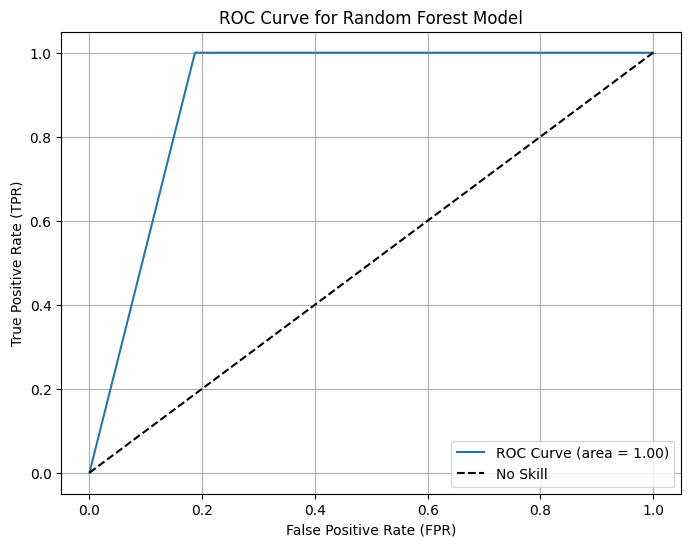

In [ ]:
plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc)

# Ideal ROC Curve for reference
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

# Customize the plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest Model')
plt.legend()
plt.grid(True)
plt.show()

#### Confusion matrix

<Axes: >

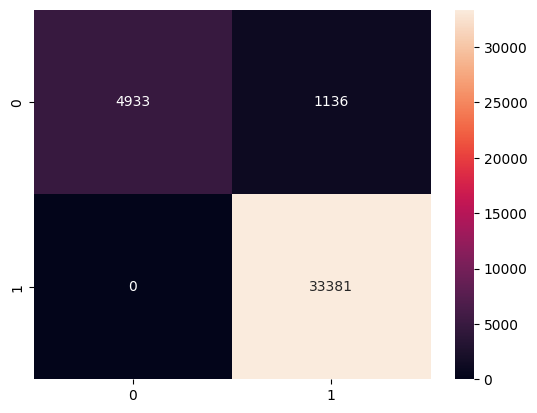

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_b, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d')

So by looking at this heatmap we have 0 FPs(!!) but we do have FN

#### Multiclass classification
In oreder to use RandomForest classifier for multilabel classification problem we will use one-vs-rest classification which consists of training a different model for each label and choosing the one with the highest probability

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

In [ ]:
rnd_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, oob_score=True))
rnd_clf.fit(X_train_full_m, y_train_full_m)

y_pred_rf_m = rnd_clf.predict(X_test_m)

Hamming loss - Measures the average number of labels that are incorrectly predicted compared to the true labels

In [ ]:
# Macro-averaged metrics
precision = precision_score(y_test_m, y_pred_rf_m, average='macro')
recall = recall_score(y_test_m, y_pred_rf_m, average='macro')
f1 = f1_score(y_test_m, y_pred_rf_m, average='macro')

# Hamming loss
from sklearn.metrics import hamming_loss
hamming_loss_value = hamming_loss(y_test_m, y_pred_rf_m)

print("Macro-averaged Precision:", precision)
print("Macro-averaged Recall:", recall)
print("Macro-averaged F1-score:", f1)
print("Hamming Loss:", hamming_loss_value)

Macro-averaged Precision: 0.8715029818342276
Macro-averaged Recall: 0.8876896500885855
Macro-averaged F1-score: 0.8676404647138335
Hamming Loss: 0.10098859315589354


In [ ]:
conf_mx = confusion_matrix(y_test_m, y_pred_rf_m)
conf_mx

array([[ 287,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  15,  210,    0,    0,    0,    0,    0,    0,   23,    0,    0,
           0,    0,    0,    0],
       [ 174,    0, 2419,    0,    0,    0,    0,    0,  128,    0,    0,
           0,    0,    0,    0],
       [   2,    0,    1, 2008,    0,  113,    0,   80,    0,    1,    0,
         320,   74,    0,    0],
       [   1,    0,    0,    0, 2309,  238,    0,    1,    2,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,   15,  396, 1645,    0,  362,    0,   20,    0,
         148,   13,    0,    0],
       [   0,    0,    0,    0,    0,    0, 2580,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   3,    0,    0,   36,  407,  249,    0, 1620,    2,    0,    0,
          81,   81,    0,    0],
       [  97,    0,    0,    0,    0,    0,    0,    0, 2392,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,    4,   67,

Normalizing the confusion matrix to see better the misclassifications

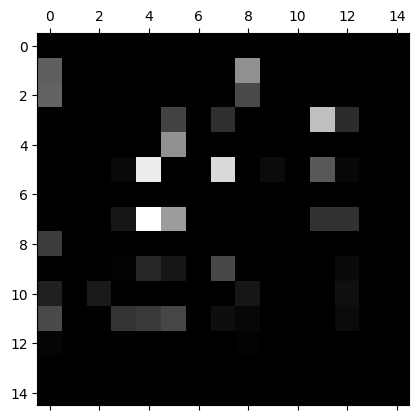

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Looking at the confusion matrix we can see that class 7 and class 5 are classified (falsely) as class 4 and somtimes as 5 or 7.

The problems and the ways to improve -
1. class imbalance can be the reason for that and more data can improve the results
2. feature analysis can help us understand what feature affects those classes and what feature might get in the way and cause misclassification
3. hyperparameter tunning and make model more complex can help

In [ ]:
forest_importances = list()

for clf in rnd_clf.estimators_:
    forest_importances.append(clf.feature_importances_)

In [ ]:
types = list()

for row in df_label["Attack_type"]:
    if row not in types:
        types.append(row)

print(types)

['MITM', 'Fingerprinting', 'Ransomware', 'Uploading', 'SQL_injection', 'DDoS_HTTP', 'DDoS_TCP', 'Password', 'Port_Scanning', 'Vulnerability_scanner', 'Backdoor', 'XSS', 'Normal', 'DDoS_UDP', 'DDoS_ICMP']


So it seems that uploading attack and DDoS_TCP are missclassified as SQL injection

In [ ]:
data = list(zip(X_test_m.columns, forest_importances[5]))
for index, row in pd.DataFrame(data, columns=['column', 'importance']).iterrows():
    if row.importance > 0:
        print(f"{row.column}: {row.importance}")

convert_hex__tcp.options: 0.003533487361824852
wrong_parse__tcp.srcport: 0.10640737272309836
normalization__icmp.checksum: 0.00392753145391125
normalization__icmp.seq_le: 0.006585312498245414
normalization__http.content_length: 0.006579574091185295
normalization__tcp.ack_raw: 0.06099083558428557
normalization__tcp.ack: 0.10557353895176631
normalization__tcp.checksum: 0.029332654690109285
normalization__tcp.dstport: 0.17224112688158685
normalization__tcp.flags: 0.15836772683111508
normalization__tcp.len: 0.11570654061771124
normalization__tcp.seq: 0.12160598413754878
normalization__udp.port: 2.2360881456995908e-05
normalization__udp.stream: 0.009863425254472976
normalization__udp.time_delta: 0.00021769115187258778
normalization__dns.qry.name: 0.00020927022814878977
normalization__mqtt.len: 0.004029902484027304
normalization__mqtt.topic_len: 0.0009941974247749674
normalization__mqtt.ver: 0.00070633714084342
binary_groups__http.file_data: 0.004385935190067722
binary_groups__http.request.u

In [ ]:
data = list(zip(X_test_m.columns, forest_importances[7]))
for index, row in pd.DataFrame(data, columns=['column', 'importance']).iterrows():
    if row.importance > 0:
        print(f"{row.column}: {row.importance}")

convert_hex__tcp.options: 9.750794304983728e-05
wrong_parse__tcp.srcport: 0.07033078861501092
normalization__icmp.checksum: 0.00413014384078472
normalization__icmp.seq_le: 0.004450934996994629
normalization__http.content_length: 0.0988316697984326
normalization__tcp.ack_raw: 0.029002926603933523
normalization__tcp.ack: 0.13027402461038742
normalization__tcp.checksum: 0.026550092532716438
normalization__tcp.dstport: 0.0710988539581558
normalization__tcp.flags: 0.07941889208959624
normalization__tcp.len: 0.07815250579187107
normalization__tcp.seq: 0.15894646050428593
normalization__udp.port: 0.0009354321073726673
normalization__udp.stream: 0.004957371784615042
normalization__udp.time_delta: 0.0006760075590257948
normalization__dns.qry.name: 0.00043115394205748143
normalization__mqtt.len: 0.0018241843665983601
normalization__mqtt.topic_len: 0.00021200903518165737
normalization__mqtt.ver: 0.0002464761092537726
binary_groups__http.file_data: 0.006756189742894332
binary_groups__http.request.

Looking at the data above we can see that both are affected more by TCP data and HTTP data which **can** indicate why they are getting confused (4 also is giving those fields more importance)

### PCA
This is an attempt to check whether or not it improves the model success rate

In [19]:
from sklearn.decomposition import PCA
import numpy as np

In [12]:
def dimensionality_reduction(X, n_components=2):
    pca = PCA()
    X_pca = pca.fit(X)

    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95) + 1
    return d, pca

In [20]:
n_components, pca = dimensionality_reduction(X_train_full_b)

X_train_reduced = pca.transform(X_train_full_b)[:, :n_components]
X_test_reduced = pca.transform(X_test_b)[:, :n_components]

In [21]:
print(f"New number of dimesions: {n_components}")

New number of dimesions: 14


In [22]:
rnd_clf_pca = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, oob_score=True)
rnd_clf_pca.fit(X_train_reduced, y_train_full_b)

y_pred_rf_pca = rnd_clf_pca.predict(X_test_reduced)

In [25]:
accuracy = accuracy_score(y_test_b, y_pred_rf_pca)
precision = precision_score(y_test_b, y_pred_rf_pca)
recall = recall_score(y_test_b, y_pred_rf_pca)
f1 = f1_score(y_test_b, y_pred_rf_pca)

# Use predict_proba for ROC curve
if hasattr(rnd_clf_pca, "predict_proba"):
  y_proba = rnd_clf_pca.predict_proba(X_test_reduced)[:, 1]
  auc = roc_auc_score(y_test_b, y_proba)
else:
  auc = None

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)

Accuracy: 0.8975158428390367
Precision: 0.8949176381488193
Recall: 0.9952472626639394
F1-score: 0.9424197108879869
AUC: 0.9232249227801601


We can see that the accuracy and precision dropped rather significantly (between 5 and 10 percent)